In [1]:
import numpy as np
from numpy import pi, sin, cos
from scipy.optimize import least_squares
from scipy import odr
import matplotlib.pyplot as plt

In [69]:
# --- パラメータ ---------------------------------------------------------
A          = 1.0               # 半径
sigma_x    = 0.01              # x ノイズ SD
sigma_y    = 0.01              # y ノイズ SD
x_offset   = 0.03              # 真の中心 X
y_offset   = -0.01             # 真の中心 Y
phi_true   = 0.02              # 真の位相 (rad)
n_points   = 16                # 1 周あたりの点数
n_MC       = 5000               # モンテカルロ試行回数
rng        = np.random.default_rng(1234)

# --- データ生成 ---------------------------------------------------------
theta_grid = np.linspace(0, 2*pi, n_points, endpoint=False)

In [70]:
def generate_sample():
    """1 試行分のノイズ付き (x, y) を返す"""
    x_clean = A * cos(theta_grid + phi_true) + x_offset
    y_clean = A * sin(theta_grid + phi_true) + y_offset
    x_noisy = x_clean + rng.normal(0, sigma_x, n_points)
    y_noisy = y_clean + rng.normal(0, sigma_y, n_points)
    return x_noisy, y_noisy

# --- ① cos/sin + オフセット + φ 同時フィット ----------------------------
def residuals_cos_sin(params, theta, x, y, A_fixed=A):
    phi, dx, dy = params
    return np.hstack([
        x - (A_fixed * np.cos(theta + phi) + dx),
        y - (A_fixed * np.sin(theta + phi) + dy)
    ])

def fit_cos_sin(theta, x, y):
    res = least_squares(residuals_cos_sin, x0=[0.0, 0.0, 0.0],
                        args=(theta, x, y))
    phi_hat, dx_hat, dy_hat = res.x
    # φ を -π–π にラップ
    phi_hat = (phi_hat + pi) % (2*pi) - pi
    # 標準誤差の計算
    dof = res.fun.size - res.x.size          # 2N - p
    s2  = res.cost * 2 / dof                 # res.cost は ½‖residual‖²
    JTJ_inv = np.linalg.inv(res.jac.T @ res.jac)
    phi_se  = np.sqrt(s2 * JTJ_inv[0, 0])

    return phi_hat, dx_hat, dy_hat, phi_se

# # --- ② ODR で円フィット → φ 推定 ---------------------------------------
def fit_circle_odr(x, y, A_fixed=A, sx_val=sigma_x, sy_val=sigma_y):
    """ODR で円フィットし (xc, yc, R) を返す"""
    # ------------------------------
    # 1) モデル（implicit=True）
    # ------------------------------
    def implicit_circle(beta, data):
        xc, yc, R = beta
        x_d, y_d = data           # data は 2×N
        return (x_d - xc)**2 + (y_d - yc)**2 - R**2

    model = odr.Model(implicit_circle, implicit=True)

    # ------------------------------
    # 2) データ：x.shape=(2, N)
    #    y=1 で implicit モデルを宣言
    # ------------------------------
    xy   = np.vstack([x, y])                       # shape=(2, N)
    sx   = np.vstack([sx_val*np.ones_like(x),      # shape=(2, N)
                         sy_val*np.ones_like(y)])
    data = odr.RealData(xy,                # x
                        y=1,               # <- 重要: implicit モデル
                        sx=sx)             # 標準偏差 (sy は不要)

    # ------------------------------
    # 3) 初期値：中心は質量中心、半径は A_fixed
    # ------------------------------
    beta0 = [x.mean(), y.mean(), A_fixed]

    odr_run = odr.ODR(data, model, beta0=beta0).run()
    return odr_run.beta #np.sqrt(sx_val**2 + sy_val**2)

def estimate_phi_from_center(x, y, xc, yc):
    angles = np.arctan2(y - yc, x - xc)          # 各点の角度
    diff   = angles - theta_grid                 # θ_i との差
    # 円周量平均を取ってラップ (-π–π)
    phi_hat = np.angle(np.mean(np.exp(1j*diff)))
    return phi_hat

def estimate_phi_and_error(x, y, xc, yc):
    """中心補正後，φ̂ とその標準誤差を返す（円周統計を利用）"""
    angles = np.arctan2(y - xc*0 - yc, x - xc)  # == np.arctan2(y-yc, x-xc)
    diff   = angles - theta_grid
    # φ̂：複素平均ベクトルの偏角
    phi_hat = np.angle(np.mean(np.exp(1j * diff)))
    # 円周統計による標準偏差 ≈ sqrt(-2 ln R)
    R_bar   = np.abs(np.mean(np.exp(1j * (diff - phi_hat))))
    circ_sd = np.sqrt(-2 * np.log(R_bar))          # Fisher (1993) 定義
    phi_se  = circ_sd / np.sqrt(len(diff))         # 標準誤差

    # wrap [-π,π]
    phi_hat = (phi_hat + pi) % (2*pi) - pi
    return phi_hat, phi_se

# --- モンテカルロ -------------------------------------------------------
phi_est1 = np.empty(n_MC)
phi_est2 = np.empty(n_MC)
phi_err1 = np.empty(n_MC)
phi_err2 = np.empty(n_MC)

for k in range(n_MC):
    x_obs, y_obs          = generate_sample()
    # ①
    phi_est1[k], _, _, phi_err1[k], = fit_cos_sin(theta_grid, x_obs, y_obs)
    # ②
    xc_hat, yc_hat, _               = fit_circle_odr(x_obs, y_obs, A_fixed=A)
    phi_est2[k], phi_err2[k]        = estimate_phi_and_error(x_obs, y_obs, xc_hat, yc_hat)

# 結果の統計
def summarize(arr):
    return np.mean(arr), np.std(arr, ddof=1)

mean1, std1 = summarize(phi_est1)
mean2, std2 = summarize(phi_est2)

print(f"Method ①:  bias={mean1 - phi_true:+.4e},  SD={std1:.4e}")
print(f"Method ②:  bias={mean2 - phi_true:+.4e},  SD={std2:.4e}")


Method ①:  bias=-3.9441e-05,  SD=2.5362e-03
Method ②:  bias=-3.9204e-05,  SD=2.5365e-03


Text(0.5, 0, '$|\\hat{\\phi} - \\phi_{true}|$ (rad)')

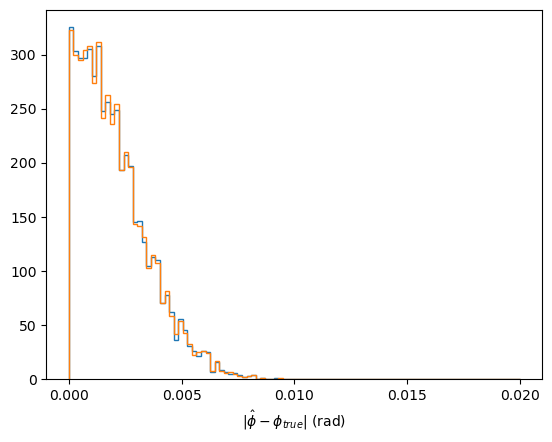

In [71]:
ax = plt.axes()
_bins = np.linspace(0., 0.02, 100)
_=ax.hist(np.abs(phi_est1 - phi_true),histtype='step',bins=_bins)
_=ax.hist(np.abs(phi_est2 - phi_true),histtype='step',bins=_bins)

ax.set_xticks(np.arange(0, 0.021, 0.005))
ax.set_xlabel(r"$|\hat{\phi} - \phi_{true}|$ (rad)")

Text(0.5, 0, 'Estimated φ error (degrees)')

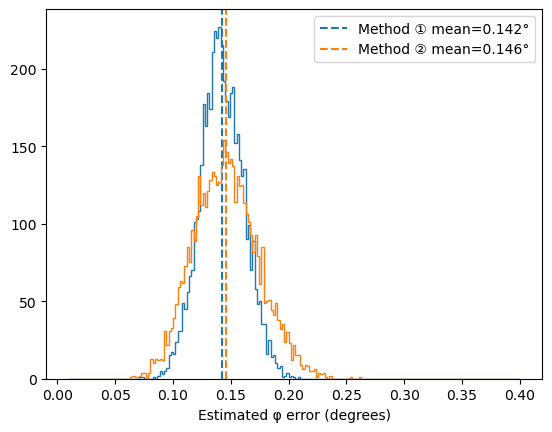

In [72]:
ax = plt.axes()
_bins = np.linspace(0.01,0.4,200)
_=ax.hist(np.rad2deg(phi_err1),histtype='step',bins=_bins)
_mean = np.mean(np.rad2deg(phi_err1))
ax.axvline(_mean, color='C0', linestyle='--', label=f'Method ① mean={_mean:.3f}°')

_=ax.hist(np.rad2deg(phi_err2),histtype='step',bins=_bins)
_mean = np.mean(np.rad2deg(phi_err2))
ax.axvline(_mean, color='C1', linestyle='--', label=f'Method ② mean={_mean:.3f}°')

ax.legend()
ax.set_xlabel('Estimated φ error (degrees)')
# ax.set_xscale('log')